# HW7 DATASCI W261: Machine Learning at Scale  
 
* **Name:**  Megan Jasek
* **Email:**  meganjasek@ischool.berkeley.edu
* **Class Name:**  W261-2
* **Week Number:**  9
* **Homework Number:**  7
* **Date:**  7/10/16

<h1 style="color:#021353;">General Description</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
In this assignment you will explore networks and develop MRJob code for 
finding shortest path graph distances. To build up to large data 
you will develop your code on some very simple, toy networks.
After this you will take your developed code forward and modify it and 
apply it to two larger datasets (performing EDA along the way).

<h3>Undirected toy network dataset</h3>


In an undirected network all links are symmetric, 
i.e., for a pair of nodes 'A' and 'B,' both of the links:

A -> B and B -> A

will exist. 

The toy data are available in a sparse (stripes) representation:

(node) \t (dictionary of links)

on AWS/Dropbox via the url:

s3://ucb-mids-mls-networks/undirected_toy.txt
On under the Data Subfolder for HW7 on Dropbox with the same file name. 
The Data folder is in: https://db.tt/Kxu48mL1)

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).


<h3>Directed toy network dataset</h3>

In a directed network all links are not necessarily symmetric, 
i.e., for a pair of nodes 'A' and 'B,' it is possible for only one of:

A -> B or B -> A

to exist. 

These toy data are available in a sparse (stripes) representation:

(node) \t (dictionary of links)

on AWS/Dropbox via the url:

s3://ucb-mids-mls-networks/directed_toy.txt
Or under the Data Subfolder for HW7 on Dropbox with the same file name
(On Dropbox https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0)

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).
</pre>
</div>

### Create test files

In [1]:
%%writefile directed_toy.txt
1	{'2': 1, '6': 1}
2	{'1': 1, '3': 1, '4': 1}
3	{'2': 1, '4': 1}
4	{'2': 1, '5': 1}
5	{'1': 1, '2': 1, '4': 1}

Overwriting directed_toy.txt


In [26]:
%%writefile d2_toy.txt
A	{'B': 1, 'E': 1000}
B	{'C': 1}
C	{'D': 1}
D	{'E': 1}
E	{'F': 1}

Overwriting d2_toy.txt


In [3]:
%%writefile d2a_toy.txt
A	{'B': 1, 'E': 4}
B	{'C': 1}
C	{'D': 1}
D	{'E': 1}
E	{'F': 1}

Writing d2a_toy.txt


In [30]:
%%writefile d3_toy.txt
A	{'B': 10, 'C': 5}
B	{'C': 2, 'D': 1}
C	{'B': 3, 'D': 9, 'E': 2}
D	{'E': 4}
E	{'A': 7, 'D': 6}

Writing d3_toy.txt


In [1]:
%%writefile d4_toy.txt
1	{"2": 1, "5": 100}
2	{"1": 1, "3": 1, "5": 1, "4": 1}
3	{"2": 1, "4": 1}
4	{"3": 1, "2": 1, "5": 1}
5	{"1": 100, "2": 1, "4": 1, "6":1}
6	{"5": 1, "7": 1}
7	{"6": 1}

Writing d4_toy.txt


In [2]:
%%writefile undirected_toy.txt
1	{'2': 1,'5': 1}
2	{'1': 1,'3': 1,'4': 1,'5': 1}
3	{'2': 1, '4': 1}
4	{'2': 1,'3': 1,'5': 1}
5	{'1': 1, '2': 1, '4': 1}

Overwriting undirected_toy.txt


<h1 style="color:#021353;">HW 7.0: Shortest path graph distances (toy networks)</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
In this part of your assignment you will develop the base of your code for the week.

Write MRJob classes to find shortest path graph distances, as described in the lectures. In addition to finding the distances, your code should also output a distance-minimizing path between the source and target.
Work locally for this part of the assignment, and use both of the undirected and directed toy networks.

To proof you code's function, run the following jobs

- shortest path in the undirected network from node 1 to node 4
Solution: 1,5,4. NOTE: There is another shortest path also (HINT: 1->5->4)! Either will suffice (you will find this also in the remaining problems. E.g., 7.2 and 7.4.
 

- shortest path in the directed network from node 1 to node 5
Solution: 1,2,4,5

and report your output---make sure it is correct!

<h3>Main dataset 1: NLTK synonyms</h3>

In the next part of this assignment you will explore a network derived from the NLTK synonym database used for evaluation in HW 5. At a high level, this network is undirected, defined so that there exists link between two nodes/words if the pair or words are a synonym. These data may be found at the location:

<a href="s3://ucb-mids-mls-networks/synNet/synNet.txt">s3://ucb-mids-mls-networks/synNet/synNet.txt</a>
<a href="s3://ucb-mids-mls-networks/synNet/indices.txt">s3://ucb-mids-mls-networks/synNet/indices.txt</a>
On under the Data Subfolder for HW7 on Dropbox with the same file names

where synNet.txt contains a sparse representation of the network:

(index) \t (dictionary of links)

in indexed form, and indices.txt contains a lookup list

(word) \t (index)

of indices and words. This network is small enough for you to explore and run
scripts locally, but will also be good for a systems test (for later) on AWS.

In the dictionary, target nodes are keys, link weights are values 
(here, all weights are 1, i.e., the network is unweighted).
</pre>
</div>

- shortest path in the undirected network from node 1 to node 4
Solution: 1,5,4. NOTE: There is another shortest path also (HINT: 1->5->4)! Either will suffice (you will find this also in the remaining problems. E.g., 7.2 and 7.4.  
**ANSWER:**  The shortest path from 1 to 4 is: 1->2->4  

- shortest path in the directed network from node 1 to node 5  
Solution: 1,2,4,5  
**ANSWER:**  The shortest path from 1 to 5 is: 1->2->4->5

### Create Single Source Shortest Path (SSSP) Initialization Class

In [1]:
%%writefile SSSPInit.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast

# This class takes an adjacency list as input and outputs and initialized work file with 
# the following format:
# node_number \t [adjacency_list, infinity, '', 'U']
# One starting node is defined as an argument passed in to the class.  The default is node '1'.
# That starting node has the format:
# node_number \t [adjacency_list, 0.0, '', 'Q']
# U means Unvisited
# Q means Queued in the queue
class MRSSSPInit(MRJob):
    def configure_options(self):
        # Configure a new command line option called 'start_index' to indicate the starting
        # index of the SSSP algorithm.
        # Configure a new command line option called 'unweighted' to make the graph unweighted.
        # If this is set to '1', then all distances from node to node are set to a weight of 1.
        super(MRSSSPInit, self).configure_options()
        self.add_passthrough_option('--start_index', type='str', default='1')
        self.add_passthrough_option('--unweighted', type='str', default='0')
    
    def __init__(self, *args, **kwargs):
        super(MRSSSPInit, self).__init__(*args, **kwargs)
        self.start_index = self.options.start_index
        self.unweighted = self.options.unweighted

    # For the node equal to the start index, yield
    #    node_number \t tuple(adj_list, 0.0, "", 'Q')
    # For all other nodes, yield
    #    node_number \t tuple(adj_list, infinity, "", 'U')    
    def mapper(self, _, line):
        node_num, adj_dict = line.strip().split('\t')
        adj_dict = ast.literal_eval(adj_dict)
        # If the graph is unweighted, then set all weights to 1
        if self.unweighted == '1':
            for key in adj_dict:
                adj_dict[key] = 1
        if node_num == self.start_index:
            yield node_num, tuple((adj_dict, 0.0, "", 'Q'))
        else:
            yield node_num, tuple((adj_dict, float('inf'), "", 'U'))
    
    # Create the steps for the MRJob.  There is only a mapper in this job.
    def steps(self):
        return [
            MRStep(mapper=self.mapper)
               ]
            
if __name__ == '__main__':
    MRSSSPInit.run()

Overwriting SSSPInit.py


### Create Single Source Shortest Path (SSSP) Class

In [2]:
%%writefile SSSP.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from collections import Counter
import ast
import json

# This class implements the Single Source Shortest Path (SSSP) breadth-first search
# algorithm for an unweighted graph in MapReduce.  The functions of the mapper and reducer
# are explained below.  Once a node is put in to the V state its shortest path has been found
# (this is not true for a weighted graph)
class MRSSSP(MRJob):
    def configure_options(self):
        # Configure a new command line option to capture the stop_index for the shortest path
        super(MRSSSP, self).configure_options()
        self.add_passthrough_option('--stop_index', type='str', default='no_stop_index')
    
    def __init__(self, *args, **kwargs):
        # Set the stop_index as a class variable
        super(MRSSSP, self).__init__(*args, **kwargs)
        self.stop_index = self.options.stop_index

    def mapper(self, _, line):
        # If a node is in the Q state then yield 2 things.  1.  The adjacency list, the
        # minimum distance and the shortest path plus its own node name as this is the shortest
        # path that will be found.  2.  All of the nodes in its adj_list each with the following:
        # An empty adjacency list, the current min_dist plus the distance to this node, the
        # current shortest path plus the path to this node, state of Q.
        node_num, data = line.strip().split('\t')
        data = json.loads(data)
        node_num = node_num.strip('"')
        adj_dict = data[0]
        min_dist = data[1]
        short_path = data[2]
        state = data[3]
        if state == 'Q':
            yield node_num, tuple((adj_dict, min_dist, short_path+node_num, 'V'))
            for node, dist in adj_dict.iteritems():
                yield node, tuple(({}, float(min_dist)+float(dist), short_path+node_num+'->', 'Q'))
        else:
            yield node_num, tuple((adj_dict, min_dist, short_path, state))
    
    # For each element in the data list, do the following:
    # - Use the adjacency list for a node that is not {}, there will always be one.
    # - Find the minimum distance of all of the elements of the list, use the shortest
    # path and state from this element as well.
    # If an element is in the Q state and there is no_stop_index, then increment the
    # 'Number_In_Q' counter
    # If an element is in the V state (meaning its shortest path has already been found) and
    # it is the stopping index, then increment the 'Stop_Index_Found' counter.
    def reducer(self, node, data):
        f_adj_dict = Counter()
        f_min_dist = float('inf')
        f_short_path = ''
        f_state = 'U'
        for adj_dict, min_dist, short_path, state in data:
            if adj_dict != {} and f_adj_dict == {}:
                f_adj_dict = adj_dict
            min_dist = float(min_dist)
            if min_dist < f_min_dist:
                f_min_dist = min_dist
                f_short_path = short_path
                f_state = state
        if f_state == 'Q' and self.stop_index == 'no_stop_index':
            self.increment_counter('SSSP_Counters', 'Number_In_Q', 1)
        elif f_state == 'V' and self.stop_index == node:
            self.increment_counter('SSSP_Counters', 'Stop_Index_Found', 1)            
        yield node, tuple((f_adj_dict, f_min_dist, f_short_path, f_state))

    def steps(self):
        # Create the steps for the MRJob.  There is only one MRJob here containing
        # a mapper and a reducer.
        return [
            MRStep(mapper=self.mapper,
                   reducer=self.reducer)
               ]
            
if __name__ == '__main__':
    MRSSSP.run()

Overwriting SSSP.py


### Driver:  directed_toy.txt from 1 to 5

In [15]:
%reload_ext autoreload
%autoreload 2
from SSSP import MRSSSP
from SSSPInit import MRSSSPInit
import json

# Set the name of the file that gets passed from iteration to iteration
work_filename = 'work_table.txt'

# Initialize the work table file
# d2_toy.txt, d2a_toy.txt and d3_toy.txt start with 'A', all others start
# with the default of '1'
start_index = '1'
#mr_job = MRSSSPInit(args=['d2_toy.txt', '--start_index', start_index, '--unweighted', '1'])
mr_job = MRSSSPInit(args=['directed_toy.txt', '--start_index', start_index, '--unweighted', '1'])
with mr_job.make_runner() as runner, open(work_filename, 'w') as f: 
    runner.run()
    # stream_output: get access of the output 
    for line in runner.stream_output():
        key, value =  mr_job.parse_output_line(line)
        f.write(key+'\t'+json.dumps(value)+'\n')

# Run the SSSP MRJob
#stop_index = 'no_stop_index'
stop_index = '5'
mr_job = MRSSSP(args=[work_filename, '--stop_index', stop_index])
    
# Update work table file iteratively
i = 0
# Set stop condition to False
Stop = False
while(Stop==False):
    work_table = {}
    # Print the iteration number
    print('Iteration %d' % (i))
    with mr_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            key,value =  mr_job.parse_output_line(line)
            print key, value
            work_table[key] = value
            if stop_index == 'no_stop_index':
                Stop = True
                if value[3] == 'Q':
                    Stop = False 
            else:
                if value[3] == 'V' and key == stop_index:
                    Stop = True
        
        # Update work_table for the next iteration
        with open(work_filename, 'w') as f:
            for key, value in work_table.iteritems():
                f.write(key+'\t'+json.dumps(value)+'\n')
    i += 1
    
if stop_index != 'no_stop_index':
    print
    print('The shortest path from %s to %s is: %s' % (start_index, stop_index, work_table[stop_index][2]))

Iteration 0
4 [{u'2': 1, u'5': 1}, inf, u'', u'U']
5 [{u'1': 1, u'2': 1, u'4': 1}, inf, u'', u'U']
6 [{}, 1.0, u'1->', u'Q']
1 [{u'2': 1, u'6': 1}, 0.0, u'1', u'V']
2 [{u'1': 1, u'3': 1, u'4': 1}, 1.0, u'1->', u'Q']
3 [{u'2': 1, u'4': 1}, inf, u'', u'U']
Iteration 1
4 [{u'2': 1, u'5': 1}, 2.0, u'1->2->', u'Q']
5 [{u'1': 1, u'2': 1, u'4': 1}, inf, u'', u'U']
6 [{}, 1.0, u'1->6', u'V']
1 [{u'2': 1, u'6': 1}, 0.0, u'1', u'V']
2 [{u'1': 1, u'3': 1, u'4': 1}, 1.0, u'1->2', u'V']
3 [{u'2': 1, u'4': 1}, 2.0, u'1->2->', u'Q']
Iteration 2
4 [{u'2': 1, u'5': 1}, 2.0, u'1->2->4', u'V']
5 [{u'1': 1, u'2': 1, u'4': 1}, 3.0, u'1->2->4->', u'Q']
6 [{}, 1.0, u'1->6', u'V']
1 [{u'2': 1, u'6': 1}, 0.0, u'1', u'V']
2 [{u'1': 1, u'3': 1, u'4': 1}, 1.0, u'1->2', u'V']
3 [{u'2': 1, u'4': 1}, 2.0, u'1->2->3', u'V']
Iteration 3
4 [{u'2': 1, u'5': 1}, 2.0, u'1->2->4', u'V']
5 [{u'1': 1, u'2': 1, u'4': 1}, 3.0, u'1->2->4->5', u'V']
6 [{}, 1.0, u'1->6', u'V']
1 [{u'2': 1, u'6': 1}, 0.0, u'1', u'V']
2 [{u'1': 1, 

### Driver:  undirected_toy.txt from 1 to 4

In [16]:
%reload_ext autoreload
%autoreload 2
from SSSP import MRSSSP
from SSSPInit import MRSSSPInit
import json

# Set the name of the file that gets passed from iteration to iteration
work_filename = 'work_table.txt'

# Initialize the work table file
# d2_toy.txt, d2a_toy.txt and d3_toy.txt start with 'A', all others start
# with the default of '1'
start_index = '1'
mr_job = MRSSSPInit(args=['undirected_toy.txt', '--start_index', start_index])
with mr_job.make_runner() as runner, open(work_filename, 'w') as f: 
    runner.run()
    # stream_output: get access of the output 
    for line in runner.stream_output():
        key, value =  mr_job.parse_output_line(line)
        f.write(key+'\t'+json.dumps(value)+'\n')

# Run the SSSP MRJob
stop_index = '4'
mr_job = MRSSSP(args=[work_filename, '--stop_index', stop_index])
    
# Update work table file iteratively
i = 0
# Set stop condition to False
Stop = False
while(Stop==False):
    work_table = {}
    # Print the iteration number
    print('Iteration %d' % (i))
    with mr_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            key,value =  mr_job.parse_output_line(line)
            print key, value
            work_table[key] = value
            if stop_index == 'no_stop_index':
                Stop = True
                if value[3] == 'Q':
                    Stop = False 
            else:
                if value[3] == 'V' and key == stop_index:
                    Stop = True
        
        # Update work_table for the next iteration
        with open(work_filename, 'w') as f:
            for key, value in work_table.iteritems():
                f.write(key+'\t'+json.dumps(value)+'\n')
    i += 1

# Print the final shortest path
if stop_index != 'no_stop_index':
    print
    print('The shortest path from %s to %s is: %s' % (start_index, stop_index, work_table[stop_index][2]))

Iteration 0
4 [{u'3': 1, u'2': 1, u'5': 1}, inf, u'', u'U']
5 [{u'1': 1, u'2': 1, u'4': 1}, 1.0, u'1->', u'Q']
1 [{u'2': 1, u'5': 1}, 0.0, u'1', u'V']
2 [{u'1': 1, u'3': 1, u'5': 1, u'4': 1}, 1.0, u'1->', u'Q']
3 [{u'2': 1, u'4': 1}, inf, u'', u'U']
Iteration 1
4 [{u'3': 1, u'2': 1, u'5': 1}, 2.0, u'1->2->', u'Q']
5 [{u'1': 1, u'2': 1, u'4': 1}, 1.0, u'1->5', u'V']
1 [{u'2': 1, u'5': 1}, 0.0, u'1', u'V']
2 [{u'1': 1, u'3': 1, u'5': 1, u'4': 1}, 1.0, u'1->2', u'V']
3 [{u'2': 1, u'4': 1}, 2.0, u'1->2->', u'Q']
Iteration 2
4 [{u'3': 1, u'2': 1, u'5': 1}, 2.0, u'1->2->4', u'V']
5 [{u'1': 1, u'2': 1, u'4': 1}, 1.0, u'1->5', u'V']
1 [{u'2': 1, u'5': 1}, 0.0, u'1', u'V']
2 [{u'1': 1, u'3': 1, u'5': 1, u'4': 1}, 1.0, u'1->2', u'V']
3 [{u'2': 1, u'4': 1}, 2.0, u'1->2->3', u'V']

The shortest path from 1 to 4 is: 1->2->4


<h1 style="color:#021353;">HW 7.1: Exploratory data analysis (NLTK synonyms)</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Using MRJob, explore the synonyms network data.
Consider plotting the degree distribution (does it follow a power law?),
and determine some of the key features, like:

number of nodes, 
number links,
or the average degree (i.e., the average number of links per node),
etc...

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).
</pre>
</div>

**ANSWER:**  

**Total Nodes:** 8,271  
**Total Edges:** 30,567.00  
**Average Degree:** 7.39  
**Degree distribution:** see section below labeled: 'OUTPUT FOR HW7.1 DEGREE DISTRIBUTION'

### Create a class for EDA of the SynNet.txt file

In [2]:
%%writefile EDAGraph.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import ast

# This class outputs the Total Nodes, Total Edges and Average Degree of an undirected
# graph.
class MREDAGraph(MRJob):
    # Initialize variables to store the total nodes and total edges
    def __init__(self, *args, **kwargs):
        super(MREDAGraph, self).__init__(*args, **kwargs)
        self.total_nodes = 0
        self.total_edges = 0
        
    # Calculate the degree of the node, then yield the degree and update
    # the total nodes by 1 and the total edges by the degree.
    def mapper(self, _, line):
        node_num, adj_dict = line.strip().split('\t')
        degree = len(ast.literal_eval(adj_dict))
        yield str(degree), 1
        self.total_nodes += 1
        self.total_edges += degree
    
# This class outputs the Total Nodes, Total Edges and Average Degree of an undirected
# graph.
class MREDAGraph(MRJob):
    # Initialize variables to store the total nodes and total edges
    def __init__(self, *args, **kwargs):
        super(MREDAGraph, self).__init__(*args, **kwargs)
        self.total_nodes = 0
        self.total_edges = 0
        
    # Calculate the degree of the node, then yield the degree and update
    # the total nodes by 1 and the total edges by the degree.
    def mapper(self, _, line):
        node_num, adj_dict = line.strip().split('\t')
        degree = len(ast.literal_eval(adj_dict))
        yield str(degree), 1
        self.total_nodes += 1
        self.total_edges += degree
    
    # In-memory combiner.  Output the total nodes and total edges for all input
    # to this mapper.  Include the ** at the beginning of the name of the key
    # so that the reducer will see these keys first.  This is an order inversion
    # pattern.
    def mapper_final(self):
        yield '**total_nodes', self.total_nodes
        yield '*total_edges', self.total_edges
    
    # Aggregate the data for each key.
    def combiner(self, key, data):
        yield key, sum(data)
    
    # Calculate the total nodes first using order inversion and yield the result.
    # Calculate the total edges and average degree and yield them.  Then sum
    # the frequencies of the node degrees and yield them.
    def reducer(self, key, data):
        if key == '**total_nodes':
            self.total_nodes = sum(data)
            yield '*total_nodes', self.total_nodes
        elif key == '*total_edges':
            self.total_edges = float(sum(data))
            yield key, self.total_edges/2.0
            yield '*average_degree', self.total_edges/self.total_nodes
        else:
            yield key, sum(data)

    # Create the steps for the MRJob.
    def steps(self):
        return [
            MRStep(mapper=self.mapper, mapper_final=self.mapper_final,
                   combiner=self.combiner,
                   reducer=self.reducer)
               ]
            
if __name__ == '__main__':
    MREDAGraph.run()

Overwriting EDAGraph.py


In [3]:
%reload_ext autoreload
%autoreload 2
from EDAGraph import MREDAGraph

# Run the EDAGraph MRJob
#mr_job = MREDAGraph(args=['synNet_100.txt'])
mr_job = MREDAGraph(args=['synNet.txt'])

# Initialize a dictionary to store the degree distribution
degree_dist = {}
with mr_job.make_runner() as runner: 
    runner.run()
    # stream_output: get access of the output 
    for line in runner.stream_output():
        key, value =  mr_job.parse_output_line(line)
        #print key, value
        if key == '*total_nodes':
            print('Total Nodes: %d' % (value))
        elif key == '*total_edges':
            print('Total Edges: %.2f' % (value))
        elif key == '*average_degree':
            print('Average Degree: %.2f' % (value))
            pass
        else:
            degree_dist[int(key)] = value
#print len(degree_dist)
#print degree_dist

Total Nodes: 8271
Total Edges: 30567.00
Average Degree: 7.39


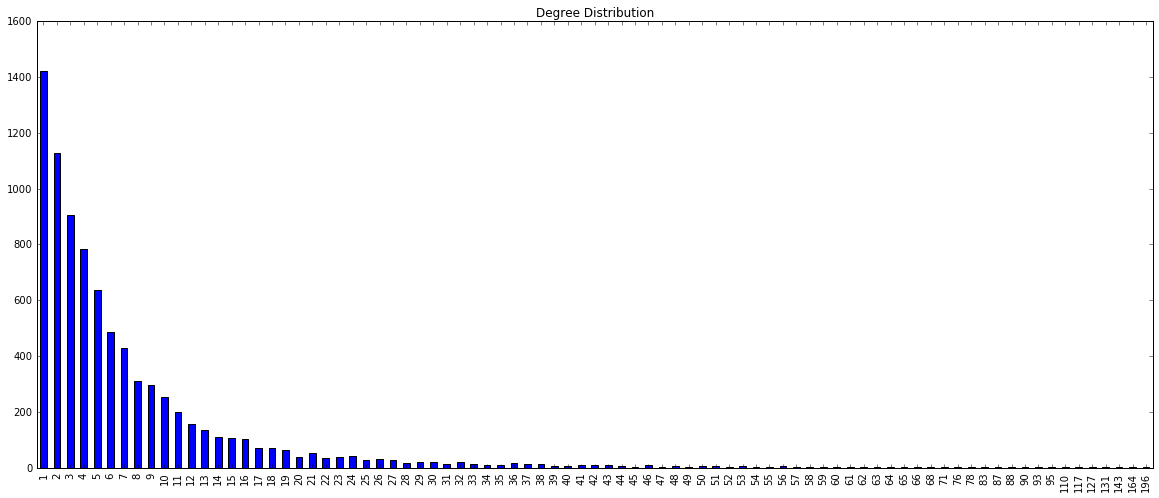

In [4]:
##### OUTPUT FOR HW7.1 DEGREE DISTRIBUTION #####
%matplotlib inline
import pandas

#http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html

# Plot a histogram of the degrees and their frequencies
df = pandas.DataFrame.from_dict(degree_dist, orient='index')
df = df.sort_index()
df.plot(kind='bar', figsize=(20,8), legend=False, 
        title='Degree Distribution')

<h1 style="color:#021353;">HW 7.2: Shortest path graph distances (NLTK synonyms)</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Write (reuse your code from 7.0) an MRJob class to find shortest path graph distances, 
and apply it to the NLTK synonyms network dataset. 

Proof your code's function by running the job:

- shortest path starting at "walk" (index=7827) and ending at "make" (index=536),

and showing you code's output. Once again, your output should include the path and the distance.

As you develop your code, please be sure to run it locally first (though on the whole dataset). 
Once you have gotten you code to run locally, deploy it on AWS as a systems test
in preparation for our next dataset (which will require AWS).

=====================================
<strong>NOTE: Dataset 2 English Wikipedia hyperlink network.data </strong>
The dataset is available via Dropbox at:

https://www.dropbox.com/sh/2c0k5adwz36lkcw/AAAAKsjQfF9uHfv-X9mCqr9wa?dl=0

For the remainder of this assignment you will explore the English Wikipedia hyperlink network.

The dataset is built from the Sept. 2015 XML snapshot of English Wikipedia.
For this directed network, a link between articles: 

A -> B

is defined by the existence of a hyperlink in A pointing to B.
This network also exists in the indexed format:

Data: <a href="s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt">s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt</a>
Data: <a href="s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt">s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-in.txt</a>
Data: <a href="s3://ucb-mids-mls-networks/wikipedia/indices.txt">s3://ucb-mids-mls-networks/wikipedia/indices.txt</a>

but has an index with more detailed data:

(article name) \t (index) \t (in degree) \t (out degree)

In the dictionary, target nodes are keys, link weights are values .
Here, a weight indicates the number of time a page links to another.
However, for the sake of this assignment, treat this an unweighted network,
and set all weights to 1 upon data input.

</pre>
</div>

- **SynNet dataset:**  shortest path starting at "walk" (index=7827) and ending at "make" (index=536)  
**ANSWER:**  
The shortest path from 7827 to 536 is: 7827->1426->1668->536  
The shortest path from 'walk' to 'make' is: 'walk'->'pass'->'Give'->'make'

In [5]:
%reload_ext autoreload
%autoreload 2
from SSSPInit import MRSSSPInit
import json

# Set the name of the file that gets passed from iteration to iteration
work_filename = 'work_table.txt'

# Initialize the work table file
start_index = '7827'
mr_job = MRSSSPInit(args=['synNet.txt', '--start_index', start_index])
#mr_job = MRSSSPInit(args=['synNet_100.txt', '--start_index', '10'])

with mr_job.make_runner() as runner, open(work_filename, 'w') as f: 
    runner.run()
    # stream_output: get access of the output 
    for line in runner.stream_output():
        key, value =  mr_job.parse_output_line(line)
        f.write(key+'\t'+json.dumps(value)+'\n')

In [6]:
%reload_ext autoreload
%autoreload 2
from SSSP import MRSSSP
import json

# Set the name of the file that gets passed from iteration to iteration
work_filename = 'work_table.txt'

# Run the SSSP MRJob
#stop_index = 'no_stop_index'
stop_index = '536'
mr_job = MRSSSP(args=[work_filename, '--stop_index', stop_index])
    
# Update work table file iteratively
i = 0
# Set start condition to True
Stop = False
while(Stop==False):
    work_table = {}
    # Print the iteration number
    print('Iteration %d' % (i))
    with mr_job.make_runner() as runner: 
        runner.run()
        # stream_output: get access of the output 
        for line in runner.stream_output():
            key,value =  mr_job.parse_output_line(line)
            #print key, value
            work_table[key] = value
            if stop_index == 'no_stop_index':
                Stop = True
                if value[3] == 'Q':
                    Stop = False 
            else:
                if value[3] == 'V' and key == stop_index:
                    Stop = True
        
        # Update work_table for the next iteration
        with open(work_filename, 'w') as f:
            for key, value in work_table.iteritems():
                f.write(key+'\t'+json.dumps(value)+'\n')
    i += 1

# Print the final shortest path
if stop_index != 'no_stop_index':
    print
    print('The shortest path from %s to %s is: %s' % (start_index, stop_index, work_table[stop_index][2]))

Iteration 0
Iteration 1
Iteration 2
Iteration 3

The shortest path from 7827 to 536 is: 7827->1426->1668->536


In [7]:
!grep '536	' work_table.txt

3536	[{"1436": 1, "1437": 1, "769": 1, "1438": 1, "1865": 1, "1864": 1, "1870": 1, "1869": 1, "402": 1}, Infinity, "", "U"]
2536	[{"2622": 1, "2621": 1, "156": 1, "3399": 1, "4010": 1, "3947": 1, "2609": 1, "4058": 1, "5461": 1, "2533": 1, "137": 1, "5336": 1, "2947": 1, "226": 1, "617": 1, "268": 1, "1192": 1, "1150": 1}, 4.0, "7827->1426->1706->137->", "Q"]
1536	[{"2713": 1, "6581": 1, "2716": 1, "1543": 1, "2714": 1, "2715": 1, "1271": 1, "4010": 1, "2034": 1, "1933": 1, "3533": 1, "3532": 1, "156": 1, "2032": 1, "2031": 1, "1934": 1, "2533": 1, "1534": 1, "2033": 1}, 4.0, "7827->1426->3551->1271->", "Q"]
5536	[{"1704": 1, "3520": 1, "5957": 1, "2771": 1, "2195": 1, "5535": 1, "5961": 1, "5963": 1, "95": 1, "1699": 1, "5967": 1}, 3.0, "7827->1426->1699->5536", "V"]
536	[{"215": 1, "3648": 1, "662": 1, "3658": 1, "3656": 1, "3657": 1, "3651": 1, "3652": 1, "3653": 1, "3555": 1, "3554": 1, "6002": 1, "3552": 1, "6000": 1, "6001": 1, "404": 1, "2248": 1, "2249": 1, "4180": 1, "2246": 1

In [7]:
# Store the results in a file called 'work_table7-2.txt'
!mv work_table.txt work_table7-2.txt
!head -1 work_table7-2.txt

3382	[{"4909": 1, "3383": 1, "3381": 1}, Infinity, "", "U"]


<h1 style="color:#021353;">HW 7.3: Exploratory data analysis (Wikipedia)</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Using MRJob, explore the Wikipedia network data on the AWS cloud. Reuse your code from HW 7.1---does is scale well? 

Be cautioned that Wikipedia is a directed network, where links are not symmetric. 
So, even though a node may be linked to, it will not appear as a primary record itself if it has no out-links. 

This means that you may have to ADJUST your code (depending on its design). 

To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.
</pre>
</div>

### Get the Wikipedia data

In [22]:
#!cd /data
#!wget http://ucb-mids-mls-networks.s3.amazonaws.com/wikipedia/all-pages-indexed-out.txt
#!wget http://ucb-mids-mls-networks.s3.amazonaws.com/wikipedia/all-pages-indexed-in.txt
#!wget http://ucb-mids-mls-networks.s3.amazonaws.com/wikipedia/indices.txt
#!cd /home/hadoop/w261-Assignments/hw7

### Load the Wikipedia data in to HDFS

In [42]:
#!hdfs dfs -mkdir /user/hadoop/HW7data
#!hdfs dfs -mkdir /user/hadoop/HW7Results
#!hdfs dfs -mkdir /user/hadoop/HW7Output
#!hdfs dfs -copyFromLocal /data/indices.txt /user/hadoop/HW7data
#!hdfs dfs -copyFromLocal /data/all-pages-indexed-in.txt /user/hadoop/HW7data
#!hdfs dfs -copyFromLocal /data/all-pages-indexed-out.txt /user/hadoop/HW7data
#!hdfs dfs -copyFromLocal synNet.txt /user/hadoop/HW7data

16/07/05 00:46:31 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/07/05 00:46:34 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [35]:
%%writefile EDADirectedGraph.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from collections import Counter
import ast

class MREDADirectedGraph(MRJob):
    def __init__(self, *args, **kwargs):
        super(MREDADirectedGraph, self).__init__(*args, **kwargs)
        self.total_nodes = 0
        self.total_edges = 0
        
    #load data and output the nearest centroid index and data point plus a count of 1. 
    def mapper(self, _, line):
        node_num, adj_dict = line.strip().split('\t')
        adj_dict = ast.literal_eval(adj_dict)
        yield '**' + node_num, 1
        for node in adj_dict:
            yield '**' + node, 1
        degree = len(adj_dict)
        yield str(degree), 1
        self.total_edges += degree
    
    def mapper_final(self):
        yield '*total_edges', self.total_edges
    
    def combiner(self, key, data):
        yield key, sum(data)
    
    #Aggregate sum for each cluster and then calculate the new centroids
    def reducer(self, key, data):
        if key[:2] == '**':
            self.total_nodes += 1
        elif key == '*total_edges':
            yield '*total_nodes', self.total_nodes
            self.total_edges = float(sum(data))
            yield key, self.total_edges
        else:
            yield key, sum(data)

    def steps(self):
        # Create the steps for the MRJob.  There is only one MRJob here containing
        # a mapper, a combiner and a reducer.
        JOBCONF_STEP = {        
            'mapreduce.job.maps': '100',
            'mapreduce.job.reduces': '1'
        }
        return [
            MRStep(jobconf=JOBCONF_STEP,
                   mapper=self.mapper, mapper_final=self.mapper_final,
                   combiner=self.combiner,
                   reducer=self.reducer)
               ]
            
if __name__ == '__main__':
    MREDADirectedGraph.run()

Overwriting EDADirectedGraph.py


In [44]:
%reload_ext autoreload
%autoreload 2
from EDADirectedGraph import MREDADirectedGraph

# Run the KMeans MRJob
#mr_job = MREDADirectedGraph(args=['synNet_100.txt'])
#mr_job = MREDADirectedGraph(args=['synNet.txt'])
#mr_job = MREDADirectedGraph(args=['synNet.txt', '-r', 'hadoop'])
ofile ='HW7Output/EDADirectedGraph'
!hdfs dfs -rm -r /user/hadoop/$ofile
mr_job = MREDADirectedGraph(args=['hdfs:///user/hadoop/HW7data/synNet.txt', '-r', 'hadoop', '--output-dir', ofile])
#mr_job = MREDADirectedGraph(args=['hdfs:///user/hadoop/HW7data/all-pages-indexed-out.txt', '-r', 'hadoop'])

degree_dist = {}
total_unique_nodes = 0
total_edges = 0
with mr_job.make_runner() as runner: 
    runner.run()
    # stream_output: get access of the output 
    for line in runner.stream_output():
        key, value =  mr_job.parse_output_line(line)
        #print key, value
        if key == '*total_nodes':
            total_unique_nodes += value
        elif key == '*total_edges':
            total_edges += value
        else:
            degree_dist[int(key)] = value

print('Total Nodes: %d' % (total_unique_nodes))
print('Total Edges Directed: %.2f' % (total_edges))
print('Total Edges Undirected: %.2f' % (total_edges/2.0))
print('Average Degree: %.2f' % (total_edges/total_unique_nodes))
print len(degree_dist)
print degree_dist

16/07/05 00:52:15 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
rm: `/user/hadoop/HW7Output/EDADirectedGraph': No such file or directory


ERROR:mrjob.fs.hadoop:STDERR: 16/07/05 00:54:23 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable



Total Nodes: 8271
Total Edges Directed: 61134.00
Total Edges Undirected: 30567.00
Average Degree: 7.39
83
{68: 3, 1: 1421, 2: 1127, 131: 1, 4: 783, 5: 637, 6: 488, 7: 429, 8: 309, 9: 296, 10: 254, 11: 200, 12: 158, 13: 135, 14: 111, 143: 2, 16: 104, 17: 70, 18: 70, 19: 62, 20: 39, 21: 51, 22: 34, 23: 40, 24: 42, 25: 26, 26: 31, 27: 26, 28: 17, 29: 21, 30: 20, 31: 14, 32: 21, 33: 14, 34: 11, 35: 10, 164: 1, 37: 13, 38: 13, 39: 7, 40: 6, 41: 8, 42: 8, 43: 10, 44: 7, 45: 4, 46: 8, 47: 2, 48: 5, 49: 4, 50: 5, 51: 7, 52: 3, 53: 6, 54: 2, 55: 4, 56: 5, 57: 3, 58: 2, 59: 3, 60: 2, 61: 2, 62: 3, 63: 1, 64: 1, 65: 2, 66: 2, 196: 1, 71: 1, 76: 2, 78: 2, 83: 1, 87: 1, 88: 1, 36: 15, 90: 1, 15: 108, 93: 1, 95: 1, 3: 906, 110: 2, 117: 1, 127: 1}


In [53]:
#!hdfs dfs -cat $ofile/part-00000 | head -20
#!hdfs dfs -cp $ofile/part-00000 /user/hadoop/HW7Results/synNet_EDA.txt
#!hdfs dfs -cat /user/hadoop/HW7Results/synNet_EDA.txt | head -20
#!hdfs dfs -copyToLocal $ofile/part-00000 wikipedia_EDA.txt
#!hdfs dfs -copyToLocal /user/hadoop/HW7Results/synNet_EDA.txt synNet_EDA.txt

16/07/05 01:55:15 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/07/05 01:55:16 WARN hdfs.DFSClient: DFSInputStream has been closed already


Total Nodes: 15192277
Total Edges Directed: 142114057.00
Total Edges Undirected: 71057028.50
Average Degree: 9.35
2062
{1: 869993, 2: 123110, 3: 160376, 4: 174474, 5: 191640, 6: 193050, 7: 201193, 8: 232863, 9: 215577, 10: 193438, 11: 186724, 12: 178481, 13: 211048, 14: 145958, 15: 134809, 16: 122792, 17: 113188, 18: 104479, 19: 97760, 20: 91767, 21: 86038, 22: 80052, 23: 75382, 24: 70876, 25: 66873, 26: 62577, 27: 58612, 28: 54757, 29: 51875, 30: 49193, 31: 46219, 32: 44474, 33: 41568, 34: 39023, 35: 36503, 36: 33887, 37: 32495, 38: 30612, 39: 29248, 40: 27655, 41: 26173, 42: 25111, 43: 24037, 44: 22626, 45: 21350, 46: 20572, 47: 19603, 48: 18922, 49: 17985, 50: 17257, 51: 16724, 52: 15714, 53: 15089, 54: 14613, 55: 14010, 56: 13623, 57: 12718, 58: 12652, 59: 12156, 60: 11525, 61: 11151, 62: 10746, 63: 10431, 64: 10249, 65: 9784, 66: 9277, 67: 9066, 68: 8760, 69: 8368, 70: 8048, 71: 7760, 72: 7517, 73: 7350, 74: 7043, 75: 6866, 76: 6727, 77: 6510, 78: 6257, 79: 6204, 80: 5978, 81: 584

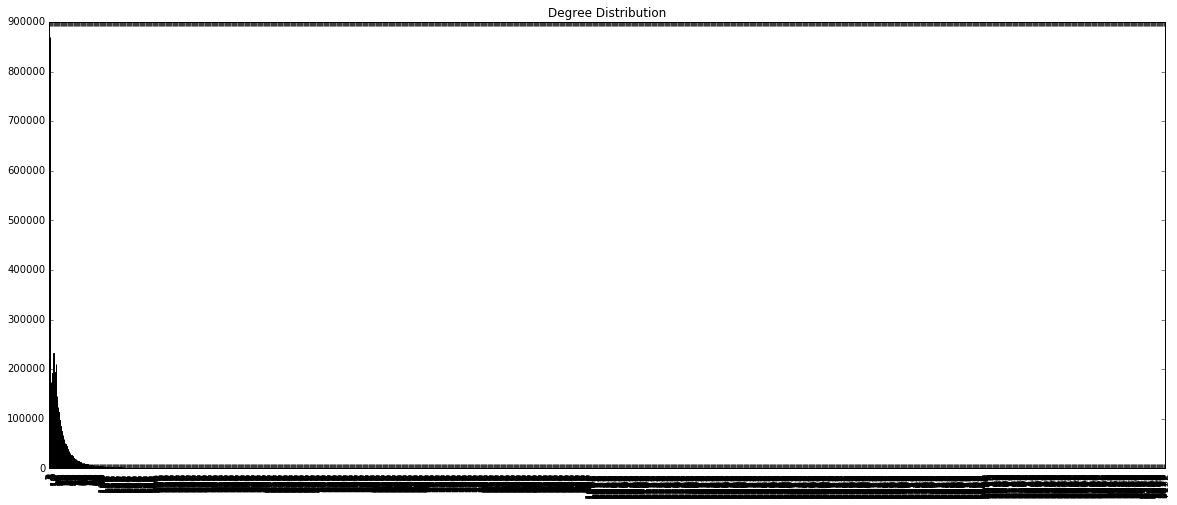

In [59]:
##### OUTPUT FOR HW5.3 5-GRAM LENGTH DISTRIBUTIONS #####
%matplotlib inline
import pandas

# Initialize a dictionary to store the lengths and frequencies
degree_dist = {}
#filename = 'synNet_EDA.txt'
filename = 'wikipedia_EDA.txt'
with open(filename, 'r') as f:
    for line in f.readlines():
        key,value =  line.strip().split('\t',2)
        key = key.strip('"')
        if key == '*total_nodes':
            total_unique_nodes = int(value)
        elif key == '*total_edges':
            total_edges = float(value)
        else:
            degree_dist[int(key)] = int(value)

print('Total Nodes: %d' % (total_unique_nodes))
print('Total Edges Directed: %.2f' % (total_edges))
print('Total Edges Undirected: %.2f' % (total_edges/2.0))
print('Average Degree: %.2f' % (total_edges/total_unique_nodes))
print len(degree_dist)
print degree_dist

#http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.plot.html

# Plot a histogram of the lengths and their frequencies
df = pandas.DataFrame.from_dict(degree_dist, orient='index')
df = df.sort_index()
df.plot(kind='bar', figsize=(20,8), legend=False, 
        title='Degree Distribution')

<h1 style="color:#021353;">HW 7.4: Shortest path graph distances (Wikipedia)</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Using MRJob, find shortest path graph distances in the Wikipedia network on the AWS cloud.
Reuse your code from 7.2, but once again be warned of Wikipedia being a directed network.
To be sure of your code's functionality in this context, run a systems test on the directed_toy.txt network.

When running your code on the Wikipedia network, proof its function by running the job:

- shortest path from "Ireland" (index=6176135) to "University of California, Berkeley" (index=13466359),

and show your code's output. Show the shortest path in terms of just page IDS but also in terms of the name of page (show of your MapReduce join skills!!)

Once your code is running, find some other shortest paths and report your results.
</pre>
</div>

shortest path from "Ireland" (index=6176135) to "University of California, Berkeley" (index=13466359)  
6176135->11607791->13466359  
Seamus Heaney   11607791        793     335  

shortest path from "Ireland" (index=6176135) to "zika virus" (index=15190949)
Early Middle Ages       3958065 1006    768  
List of epidemics       7844602 47      564  
Chikungunya     2786273 34      217  
zika virus      15190949        1       0  
6176135->3958065->7844602->2786273->15190949  

The Gypsy's Warning     12786273        1       0  

shortest path from "Ireland" (index=6176135) to "Who's Your Daddy?" 13958065  
Thin Lizzy      12944239        1141    355  
Kiss (band)     7173161 2910    505  
Lordi   8011223 351     228  
Deadache        3529375 20      62  
Who's Your Daddy?       13958065        4       15  

"13958065"	[{"13958064": 1, "13958066": 1, "13958056": 1, "13958060": 1, "13958058": 1, "13958062": 1, "1887659": 1, "7067041": 1, "13958059": 1, "11210989": 1, "13958054": 1, "13958057": 1, "2839837": 1, "13958137": 1, "13958045": 1}, 5.0, "6176135->12944239->7173161->8011223->3529375->13958065", "V"]

Just for some type 3 fun reporting.  I let my algo run for 69 iterations with no stop-index.   Here are the results of the file from that iteration:  
Qs:  3  
Vs:  13,259,666  
Us:  1,204,989  

3 f'ing Qs and 1 million Us.  I wonder how long it would take for that thing to finish.  It was running for about 20 hours.

**Shortest Path:**  
Ireland (index=6176135)  
Seamus Heaney (index=11607791)  
University of California, Berkeley (index=13466359)  

**Shortest Path:**  
Ireland (index=6176135)  
Early Middle Ages (index=3958065)  
List of epidemics (index=7844602)  
Chikungunya (index=2786273)  
zika virus (index=15190949)  

**Shortest Path:**  
Ireland (index=6176135)  
Thin Lizzy (index=12944239)  
Kiss (band) (index=7173161)  
Lordi (index=8011223)  
Deadache (index=3529375)  
Who's Your Daddy? (index=13958065)  

In [26]:
!hdfs dfs -copyFromLocal directed_toy.txt /user/hadoop/HW7data

16/07/05 21:36:24 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
%reload_ext autoreload
%autoreload 2
from SSSPInit import MRSSSPInit

work_filename = 'work_table.txt'
ofile ='HW7Output/SSSPInit'
!hdfs dfs -rm -r /user/hadoop/$ofile
mr_job = MRSSSPInit(args=['hdfs:///user/hadoop/HW7data/synNet.txt', '-r', 'hadoop', '--start_index=7827', '--output-dir', ofile])
#mr_job = MRSSSPInit(args=['hdfs:///user/hadoop/HW7data/directed_toy.txt', '-r', 'hadoop', '--output-dir', ofile])
#mr_job = MRSSSPInit(args=['synNet.txt', '--start_index', '7827'])
#mr_job = MRSSSPInit(args=['synNet_100.txt', '--start_index', '10'])
#mr_job = MRSSSPInit(args=['synNet_20.txt', '--start_index', '10'])

with mr_job.make_runner() as runner, open(work_filename, 'w') as f: 
    runner.run()
    # stream_output: get access of the output 
    for line in runner.stream_output():
        key, value =  mr_job.parse_output_line(line)
        print key, value
        f.write(key+'\t'+json.dumps(value)+'\n')
        #f.write(key+'\t'+str(value)+'\n')
    print(runner.counters())

NameError: name 'mr_job' is not defined

In [19]:
#!hdfs dfs -mkdir /user/hadoop/HW7Input
#!hdfs dfs -cp /user/hadoop/HW7Output/SSSPInit /user/hadoop/HW7Input/SSSPInit
#!hdfs dfs -rm -r /user/hadoop/HW7Results/SSSPInit_synNet
#!hdfs dfs -cp /user/hadoop/HW7Output/SSSPInit /user/hadoop/HW7Results/SSSPInit_synNet
#!hdfs dfs -cat /user/hadoop/HW7Results/SSSPInit_d_toy/part-00001

#!hdfs dfs -cp /user/hadoop/HW7Output/SSSPInit /user/hadoop/HW7Results/SSSPInit_wikipedia
#!hdfs dfs -cat /user/hadoop/HW7Output/SSSPInit/part-00001 | head -5

#!hdfs dfs -ls /user/hadoop/HW7Output/SSSPInit
#!hdfs dfs -cp /user/hadoop/HW7Output/SSSPInit /user/hadoop/HW7Results/SSSPInit_wikipedia_gypsy
#!hdfs dfs -cat /user/hadoop/HW7Results/SSSPInit_wikipedia_gypsy/part-00015 | grep -c Q
!hdfs dfs -rm -r /user/hadoop/HW7Results/SSSPInit_wikipedia_gypsy


#!hdfs dfs -rm -r /user/hadoop/HW7Results/SSSPInit_d_toy
#!hdfs dfs -cp /user/hadoop/HW7Output/SSSPInit /user/hadoop/HW7Results/SSSPInit_d_toy
#!hdfs dfs -ls /user/hadoop/HW7Output/SSSPInit
#!hdfs dfs -ls /user/hadoop/HW7Results/SSSPInit_synNet
#!hdfs dfs -cat /user/hadoop/HW7Output/SSSPInit/part-00000 | head -5
#!hdfs dfs -copyToLocal /user/hadoop/HW7Output/SSSPInit/part-00001 SSSP_d_toy2.txt

16/07/07 11:40:38 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/07/07 11:40:39 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/HW7Results/SSSPInit_wikipedia_gypsy


In [39]:
ofile ='HW7Output/SSSPInit'
#!hdfs dfs -cat $ofile/part-00000 | grep Q
#!hdfs dfs -cat $ofile/part-00001 | grep Q
#!hdfs dfs -cat $ofile/part-00002 | grep Q
#!hdfs dfs -cat $ofile/part-00003 | grep Q
#!hdfs dfs -cat $ofile/part-00004 | grep Q
#!hdfs dfs -cat $ofile/part-00005 | grep Q
#!hdfs dfs -cat $ofile/part-00006 | grep Q
#!hdfs dfs -cat $ofile/part-00007 | grep Q
#!hdfs dfs -cat $ofile/part-00008 | grep Q
#!hdfs dfs -cat $ofile/part-00009 | grep Q
#!hdfs dfs -cat $ofile/part-00010 | grep Q
#!hdfs dfs -cat $ofile/part-00011 | grep Q
#!hdfs dfs -cat $ofile/part-00012 | grep Q
#!hdfs dfs -cat $ofile/part-00013 | grep Q
#!hdfs dfs -cat $ofile/part-00014 | grep Q
#!hdfs dfs -cat $ofile/part-00015 | grep Q
#!hdfs dfs -cat $ofile/part-00000 | head
#!hdfs dfs -cat $ofile/part-00001 | head
#!cat work_table_init_synNet.txt | head
#!hdfs dfs -cat $ofile/part-00001 | grep Q
#!hdfs dfs -cp $ofile/part-00000 /user/hadoop/HW7Results/synNet_EDA.txt
#!hdfs dfs -cat /user/hadoop/HW7Results/synNet_EDA.txt | head -20
#!hdfs dfs -copyToLocal $ofile/part-00000 wikipedia_EDA.txt
#!hdfs dfs -copyToLocal /user/hadoop/HW7Results/synNet_EDA.txt synNet_EDA.txt

In [20]:
print(369906+374353+372948+369808+367461+364305+370867+373471+371803+369771+372389+370621+372097+374391+369104+217995)
#!hdfs dfs -cat $ofile/part-00015 | grep Q

5781290
16/07/05 12:00:02 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [30]:
s = "73\t{'14417532': 1}\tinf\t\tU"
s = s.strip('"')
print s

73	{'14417532': 1}	inf		U


In [34]:
#!hdfs dfs -cat /user/hadoop/HW7Input/SSSP/part-00000 | head -10
!hdfs dfs -copyToLocal hdfs:///user/hadoop/HW7Input/SSSP/part-00000 SSSP_synNet1.txt
!hdfs dfs -copyToLocal hdfs:///user/hadoop/HW7Input/SSSP/part-00001 SSSP_synNet2.txt

16/07/05 13:29:49 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/07/05 13:29:50 WARN hdfs.DFSClient: DFSInputStream has been closed already
16/07/05 13:29:52 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/07/05 13:29:53 WARN hdfs.DFSClient: DFSInputStream has been closed already


In [5]:
#!hdfs dfs -rm -r /user/hadoop/HW7Input/SSSP
#!hdfs dfs -cp /user/hadoop/HW7Results/SSSPInit_synNet /user/hadoop/HW7Input/SSSP
#!hdfs dfs -ls /user/hadoop/HW7Input/SSSP
#!hdfs dfs -mkdir /user/hadoop/TestDir
#!hdfs dfs -mv /user/hadoop/HW7Input/SSSP /user/hadoop/TestDir
#!hdfs dfs -ls /user/hadoop/TestDir
!hdfs dfs -cat /user/hadoop/HW7Input/SSSP/part-00000 | head -5
!hdfs dfs -cat /user/hadoop/HW7Results/SSSPInit_synNet/part-00000 | head -5

16/07/05 16:54:34 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
"1"	[{"3": 1, "2": 1, "4": 1}, Infinity, "", "U"]
"10"	[{"11": 1, "13": 1, "12": 1, "15": 1, "14": 1, "17": 1, "16": 1}, Infinity, "", "U"]
"100"	[{"3827": 1, "2872": 1, "2871": 1, "2870": 1, "2875": 1, "2874": 1, "617": 1, "2441": 1, "5550": 1, "5336": 1, "93": 1, "92": 1, "3720": 1, "3722": 1, "2873": 1, "3122": 1, "2443": 1, "4647": 1, "360": 1}, Infinity, "", "U"]
"1000"	[{"997": 1, "1003": 1, "1004": 1, "999": 1, "1002": 1, "1001": 1}, Infinity, "", "U"]
"1001"	[{"997": 1, "999": 1, "998": 1, "1000": 1}, Infinity, "", "U"]
cat: Unable to write to output stream.
16/07/05 16:54:36 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
null	"1\t{'2': 1, '3': 1, '4': 1}\tinf\t\tU"
null	"2\t{'1': 1, '3': 1, '4': 1, '310': 1, '311': 1}\tinf\t\tU"
null	"3\t{'1': 1, '2'

In [30]:
!hdfs dfs -cat /user/hadoop/HW7Results/SSSPInit_d_toy/part-00000
!hdfs dfs -cat /user/hadoop/HW7Results/SSSPInit_d_toy/part-00001

16/07/06 23:04:03 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
"1"	[{"2": 1, "6": 1}, 0.0, "", "Q"]
"2"	[{"1": 1, "3": 1, "4": 1}, Infinity, "", "U"]
"3"	[{"2": 1, "4": 1}, Infinity, "", "U"]
16/07/06 23:04:05 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
"4"	[{"2": 1, "5": 1}, Infinity, "", "U"]
"5"	[{"1": 1, "2": 1, "4": 1}, Infinity, "", "U"]


In [37]:
%reload_ext autoreload
%autoreload 2
from SSSP import MRSSSP

# Run the SSSP MRJob
!hdfs dfs -rm -r /user/hadoop/HW7Output/SSSP
!hdfs dfs -rm -r /user/hadoop/HW7Input/SSSP
#!hdfs dfs -cp /user/hadoop/HW7Results/SSSPInit_synNet /user/hadoop/HW7Input/SSSP
!hdfs dfs -cp /user/hadoop/HW7Results/SSSPInit_d_toy /user/hadoop/HW7Input/SSSP
#!hdfs dfs -cp /user/hadoop/HW7Results/SSSPInit_wikipedia /user/hadoop/HW7Input/SSSP
mr_job = MRSSSP(args=['hdfs:///user/hadoop/HW7Input/SSSP', '-r', 'hadoop', '--output-dir', 'HW7Output/SSSP', '--no-output'])
stop_index = '6'
mr_job = MRSSSP(args=['hdfs:///user/hadoop/HW7Input/SSSP', '-r', 'hadoop', '--stop_index', stop_index, '--output-dir', 'HW7Output/SSSP', '--no-output'])
    
# Update work table file iteratively
i = 0
# Set start condition to True
Stop = False
while(Stop==False):
    # Print the iteration number
    print('Iteration %d' % (i))
    with mr_job.make_runner() as runner: 
        runner.run()
        print runner.counters()[0]
        if stop_index == '':
            Stop = True
            if 'SSSP_Counters' in runner.counters()[0]:
                Stop = False
        else:
            if 'SSSP_Counters' in runner.counters()[0]:
                Stop = True
    if (Stop==False):
        !hdfs dfs -rm -r /user/hadoop/HW7Input/SSSP
        !hdfs dfs -mv /user/hadoop/HW7Output/SSSP /user/hadoop/HW7Input/SSSP
    i += 1

16/07/06 23:35:10 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/07/06 23:35:10 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/HW7Output/SSSP
16/07/06 23:35:12 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/07/06 23:35:13 INFO fs.TrashPolicyDefault: Namenode trash configuration: Deletion interval = 0 minutes, Emptier interval = 0 minutes.
Deleted /user/hadoop/HW7Input/SSSP
16/07/06 23:35:14 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
16/07/06 23:35:15 WARN hdfs.DFSClient: DFSInputStream has been closed already
16/07/06 23:35:16 WARN hdfs.DFSClient: DFSInputStream has been closed already
16/07/06 23:35:16 WARN hdfs.DFSClient: DFSInputStream h

Iteration 0
{'Map-Reduce Framework': {'Spilled Records': 14, 'Total committed heap usage (bytes)': 721944576, 'Reduce output records': 6, 'GC time elapsed (ms)': 218, 'Reduce input records': 7, 'Combine input records': 0, 'Reduce input groups': 6, 'Map output bytes': 274, 'CPU time spent (ms)': 2380, 'Combine output records': 0, 'Input split bytes': 306, 'Map input records': 5, 'Map output materialized bytes': 306, 'Physical memory (bytes) snapshot': 956506112, 'Shuffled Maps ': 3, 'Map output records': 7, 'Reduce shuffle bytes': 306, 'Virtual memory (bytes) snapshot': 8471924736, 'Failed Shuffles': 0, 'Merged Map outputs': 3}, 'File Output Format Counters ': {'Bytes Written': 246}, 'Job Counters ': {'Total time spent by all maps in occupied slots (ms)': 7350, 'Total vcore-seconds taken by all map tasks': 7350, 'Launched map tasks': 3, 'Launched reduce tasks': 1, 'Total vcore-seconds taken by all reduce tasks': 3437, 'Total megabyte-seconds taken by all reduce tasks': 3519488, 'Total m

Iteration 1
{'SSSP_Counters': {'Stop_Index_Found': 1}, 'Map-Reduce Framework': {'Spilled Records': 18, 'Total committed heap usage (bytes)': 525860864, 'Reduce output records': 6, 'GC time elapsed (ms)': 321, 'Reduce input records': 9, 'Combine input records': 0, 'Reduce input groups': 6, 'Map output bytes': 335, 'CPU time spent (ms)': 2060, 'Combine output records': 0, 'Input split bytes': 204, 'Map input records': 6, 'Map output materialized bytes': 365, 'Physical memory (bytes) snapshot': 656580608, 'Shuffled Maps ': 2, 'Map output records': 9, 'Reduce shuffle bytes': 365, 'Virtual memory (bytes) snapshot': 6291689472, 'Failed Shuffles': 0, 'Merged Map outputs': 2}, 'File Output Format Counters ': {'Bytes Written': 250}, 'Job Counters ': {'Total time spent by all maps in occupied slots (ms)': 11211, 'Total vcore-seconds taken by all map tasks': 11211, 'Launched map tasks': 2, 'Launched reduce tasks': 1, 'Total vcore-seconds taken by all reduce tasks': 4328, 'Total megabyte-seconds t

In [36]:
!hdfs dfs -cat /user/hadoop/HW7Output/SSSP/part-00000

16/07/06 23:34:37 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
"1"	[{"2": 1, "6": 1}, 0.0, "1", "V"]
"2"	[{"1": 1, "3": 1, "4": 1}, 1.0, "1->2", "V"]
"3"	[{"2": 1, "4": 1}, 2.0, "1->2->3", "V"]
"4"	[{"2": 1, "5": 1}, 2.0, "1->2->4", "V"]
"5"	[{"1": 1, "2": 1, "4": 1}, 3.0, "1->2->4->", "Q"]
"6"	[{}, 1.0, "1->6", "V"]


In [22]:
%%writefile SSSP_driver.py
from SSSP import MRSSSP
import subprocess

# Run the SSSP MRJob
try:
    subprocess.check_call(['hdfs', 'dfs', '-rm', '-r', '/user/hadoop/HW7Output/SSSP'])
except:
    pass
try:
    subprocess.check_call(['hdfs', 'dfs', '-rm', '-r', '/user/hadoop/HW7Input/SSSP'])
except:
    pass
#subprocess.check_call(['hdfs', 'dfs', '-cp', '/user/hadoop/HW7Results/SSSPInit_synNet', '/user/hadoop/HW7Input/SSSP'])
#subprocess.check_call(['hdfs', 'dfs', '-cp', '/user/hadoop/HW7Results/SSSPInit_d_toy', '/user/hadoop/HW7Input/SSSP'])
subprocess.check_call(['hdfs', 'dfs', '-cp', '/user/hadoop/HW7Results/SSSPInit_wikipedia', '/user/hadoop/HW7Input/SSSP'])
# Berkeley
#stop_index = '13466359'
# Zika virus
#stop_index = '15190949'
# Who's Your Daddy
stop_index = '13958065'
mr_job = MRSSSP(args=['hdfs:///user/hadoop/HW7Input/SSSP', '-r', 'hadoop', '--stop_index', stop_index, '--output-dir', 'HW7Output/SSSP', '--no-output'])
#mr_job = MRSSSP(args=['hdfs:///user/hadoop/HW7Input/SSSP', '-r', 'hadoop', '--output-dir', 'HW7Output/SSSP', '--no-output'])
    
i = 0
# Set stop condition to False
Stop = False
while(Stop==False):
    # Print the iteration number
    print('Iteration %d' % (i))
    with mr_job.make_runner() as runner: 
        runner.run()
        if stop_index == '':
            Stop = True
            if 'SSSP_Counters' in runner.counters()[0]:
                Stop = False
        else:
            if 'SSSP_Counters' in runner.counters()[0]:
                Stop = True
    if (Stop==False):
        subprocess.check_call(['hdfs', 'dfs', '-rm', '-r', '/user/hadoop/HW7Input/SSSP'])
        subprocess.check_call(['hdfs', 'dfs', '-mv', '/user/hadoop/HW7Output/SSSP', '/user/hadoop/HW7Input/SSSP'])
    i += 1

Overwriting SSSP_driver.py


6176135->12944239->7173161->8011223->3529375->13958065
[u'6176135', u'12944239', u'7173161', u'8011223', u'3529375', u'13958065']


In [3]:
#!hdfs dfs -rm -r /user/hadoop/HW7Output/SSSP
#!hdfs dfs -ls /user/hadoop/HW7Output/SSSP
#!hdfs dfs -cat /user/hadoop/HW7Output/SSSP/part-00000 | head -3
!hdfs dfs -cat /user/hadoop/HW7Output/SSSP/part-00000 | grep '"13958065"	'
#!hdfs dfs -cp /user/hadoop/HW7Output/SSSP /user/hadoop/HW7Results/SSSP_wikipedia_daddy

#!hdfs dfs -ls /user/hadoop/HW7Results/SSSPInit_synNet
#!hdfs dfs -cat /user/hadoop/HW7Results/SSSPInit_synNet/part-00000 | head -3
#!hdfs dfs -cat /user/hadoop/HW7Results/SSSPInit_synNet/part-00001 | grep Q

#!hdfs dfs -ls /user/hadoop/HW7Results/SSSPInit_d_toy
#!hdfs dfs -cat /user/hadoop/HW7Results/SSSPInit_d_toy/part-00000
#!hdfs dfs -cat /user/hadoop/HW7Results/SSSPInit_d_toy/part-00001

#!hdfs dfs -ls /user/hadoop/HW7Input/SSSP
#!hdfs dfs -cat /user/hadoop/HW7Input/SSSP/part-00000 | head -3
#!hdfs dfs -cat /user/hadoop/HW7Input/SSSP/part-00000 | grep Q
#!hdfs dfs -copyToLocal /user/hadoop/HW7Input/SSSP/part-00001 SSSP_d_toy_iter1b.txt

16/07/07 21:14:54 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
"13958065"	[{"13958064": 1, "13958066": 1, "13958056": 1, "13958060": 1, "13958058": 1, "13958062": 1, "1887659": 1, "7067041": 1, "13958059": 1, "11210989": 1, "13958054": 1, "13958057": 1, "2839837": 1, "13958137": 1, "13958045": 1}, 5.0, "6176135->12944239->7173161->8011223->3529375->13958065", "V"]


### Create test files for MRJob Join class

In [42]:
%%writefile index_test.txt
George IV of the United Kingdom#Early life	5000000	2	0
George IV of the United Kingdom#Regency crisis of 1788	5000001	6	0
George IV of the United Kingdom#Regency	5000002	5	0
George IV	5000003	111	0
George IV#Reign	5000004	1	0
George IV, Brixton	5000005	1	8
George IV, Count of Erbach-Fürstenau	5000006	1	11
George IX of Imereti	5000007	11	18
George IX of Kartli	5000008	16	12
George IX	5000009	1	2
George Iacob	5000010	1	0
George Iacobescu	5000011	6	22
George Iacovou	5000012	7	0
George Iain Murray, 10th Duke of Atholl	5000013	1	0
George Ian Andrews	5000014	1	0
George Ian MacLean	5000015	7	8
George Iane	5000016	1	0
George Iashvili	5000017	1	0

Overwriting index_test.txt


In [70]:
%%writefile SSSP_node_list.txt
[{"5000002": 1}, {"5000006": 4}, {"5000007": 0}, {"5000009": 2}, {"5000010": 3}]

Overwriting SSSP_node_list.txt


In [89]:
%%writefile SSSPJoin.py
from mrjob.job import MRJob
from mrjob.step import MRStep
import json

class MRSSSPJoin(MRJob):
    def __init__(self, *args, **kwargs):
        super(MRSSSPJoin, self).__init__(*args, **kwargs)
        self.node_list = json.loads(open('SSSP_node_list.txt').readline())
        self.cur_node_index = 0
        self.cur_node_name, self.cur_node_order = self.node_list[self.cur_node_index].items()[0]
        self.node_list_len = len(self.node_list)
    
    #load data and output the nearest centroid index and data point plus a count of 1. 
    def mapper(self, _, line):
        # format of line from indices.txt:  (article name) \t (index) \t (in degree) \t (out degree)
        article_name, index, _, _ = line.strip().split('\t')
        if index == self.cur_node_name:
            yield self.cur_node_order, tuple((self.cur_node_name, article_name))
            self.cur_node_index +=1
            if self.cur_node_index == self.node_list_len:
                return
            else:
                self.cur_node_name, self.cur_node_order = self.node_list[self.cur_node_index].items()[0]
    
    def reducer(self, _, data):
        for d in data:
            yield None, d
    
    def steps(self):
        JOB_CONF = {
            'mapreduce.job.maps': 1,
            'mapreduce.job.reduces': 1
            }
        # Create the steps for the MRJob.  There is only one MRJob here containing
        # a mapper and a reducer.
        return [MRStep(jobconf=JOB_CONF,
                       mapper=self.mapper,
                       reducer=self.reducer)]
            
if __name__ == '__main__':
    MRSSSPJoin.run()

Overwriting SSSPJoin.py


In [92]:
import json
def write_node_list(result_dir, stop_index, filename):
    grep_output = !hdfs dfs -cat /user/hadoop/HW7Results/$result_dir/part-00000 | grep '"$stop_index"	'
    _, data = grep_output[1].strip().split('\t')
    data = json.loads(data)
    node_list = data[2].split('->')
    node_list = sorted([{int(node): i} for i, node in enumerate(node_list)])
    with open(filename, 'w') as f:
        f.write(json.dumps(node_list)+'\n')

In [98]:
%reload_ext autoreload
%autoreload 2
from SSSPJoin import MRSSSPJoin
write_node_list('SSSP_wikipedia_berkeley', '13466359', 'SSSP_node_list.txt')
mr_job = MRSSSPJoin(args=['/data/hw7/indices.txt', '--file=SSSP_node_list.txt'])
#mr_job = MRSSSPJoin(args=['index_test.txt', '--file=SSSP_node_list.txt'])
with mr_job.make_runner() as runner: 
    runner.run()
    print('Shortest Path:')
    # stream_output: get access of the output 
    for line in runner.stream_output():
        _, value =  mr_job.parse_output_line(line)
        print('%s (index=%s)' % (value[1], value[0]))

Shortest Path:
Ireland (index=6176135)
Seamus Heaney (index=11607791)
University of California, Berkeley (index=13466359)


In [97]:
%reload_ext autoreload
%autoreload 2
from SSSPJoin import MRSSSPJoin
write_node_list('SSSP_wikipedia_zikavirus', '15190949', 'SSSP_node_list.txt')
mr_job = MRSSSPJoin(args=['/data/hw7/indices.txt', '--file=SSSP_node_list.txt'])
with mr_job.make_runner() as runner: 
    runner.run()
    print('Shortest Path:')
    # stream_output: get access of the output 
    for line in runner.stream_output():
        _, value =  mr_job.parse_output_line(line)
        print('%s (index=%s)' % (value[1], value[0]))

Shortest Path:
Ireland (index=6176135)
Early Middle Ages (index=3958065)
List of epidemics (index=7844602)
Chikungunya (index=2786273)
zika virus (index=15190949)


In [96]:
%reload_ext autoreload
%autoreload 2
from SSSPJoin import MRSSSPJoin
write_node_list('SSSP_wikipedia_daddy', '13958065', 'SSSP_node_list.txt')
mr_job = MRSSSPJoin(args=['/data/hw7/indices.txt', '--file=SSSP_node_list.txt'])
with mr_job.make_runner() as runner: 
    runner.run()
    print('Shortest Path:')
    # stream_output: get access of the output 
    for line in runner.stream_output():
        _, value =  mr_job.parse_output_line(line)
        print('%s (index=%s)' % (value[1], value[0]))

Shortest Path:
Ireland (index=6176135)
Thin Lizzy (index=12944239)
Kiss (band) (index=7173161)
Lordi (index=8011223)
Deadache (index=3529375)
Who's Your Daddy? (index=13958065)


<h1 style="color:#021353;">HW 7.5: Conceptual exercise: Largest single-source network distances</h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Suppose you wanted to find the largest network distance from a single source,
i.e., a node that is the furthest (but still reachable) from a single source.

How would you implement this task? 
How is this different from finding the shortest path graph distances?

Is this task more difficult to implement than the shortest path distance?

As you respond, please comment on program structure, runtimes, iterations, general system requirements, etc...
</pre>
</div>

<h1 style="color:#021353;">HW 7.5.1: </h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Can we utilize combiners in the HW 7 to perform the shortest path implementation?
Does order inversion help with the HW 7 shortest path implementation?
</pre>
</div>

<h1 style="color:#021353;">HW 7.5.2: OPTIONAL </h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Implement combiners in the context of HW 7.5 and contrast the performance of this implementation versus the implementation with no combiners. 

Please report the cluster configuration and runtimes in tabular format for both experiments and comment on your findings.
</pre>
</div>

<h1 style="color:#021353;">HW 7.6: Computational exercise: Largest single-source network distances: OPTIONAL </h1>
<div style="margin:10px;border-left:5px solid #eee;">
<pre style="font-family:sans-serif;background-color:transparent">
Using MRJob, write a code to find the largest graph distance and distance-maximizing nodes from a single-source.
Test your code first on the toy networks and synonyms network to proof its function.
</pre>
</div>

==================END HW 7==================

In [27]:
#%%writefile SSSP_driver.py
import subprocess

#from subprocess import call
#call(["aws", "s3", "rm", "s3://w261kzm/week7/output/", "--recursive"])	

stop_index = '13958065'

# Run the SSSP MRJob
grep_output = !hdfs dfs -cat /user/hadoop/HW7Output/SSSP/part-00000 | grep '"$stop_index"	'
print grep_output

['16/07/07 22:09:22 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable', '"13958065"\t[{"13958064": 1, "13958066": 1, "13958056": 1, "13958060": 1, "13958058": 1, "13958062": 1, "1887659": 1, "7067041": 1, "13958059": 1, "11210989": 1, "13958054": 1, "13958057": 1, "2839837": 1, "13958137": 1, "13958045": 1}, 5.0, "6176135->12944239->7173161->8011223->3529375->13958065", "V"]']
